In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
from nltk.corpus import words
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import heapq
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

tqdm.pandas()

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

In [2]:
# Load the datasets
g_scores = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
g_tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
# imdb = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')
# links = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
movies = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')
tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
train = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
test = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
subm = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/sample_submission.csv')

##  Inspect Data

Inspect data and check for missing values

In [3]:
print("Train: ")
print(train.info())
print("************")
print("Test: ")
print(test.info())
print("************")
print("Tags: ")
print(tags.info())
print("************")
print("Movies: ")
print(movies.info())
print("************")
#print("Links: ")
#print(links.info())
#print("************")
#print("IMDB: ")
#print(imdb.info())
#print("************")
print("Genome Tags: ")
print(g_tags.info())
print("************")
print("Genome Scores: ")
print(g_scores.info())

Train: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None
************
Test: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB
None
************
Tags: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3

In [4]:
print("Train: ")
print(str(train.isnull().sum()))
print("************")
print("Test: ")
print(str(test.isnull().sum()))
print("************")
print("Tags: ")
print(str(tags.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies.isnull().sum()))
print("************")
#print("Links: ")
#print(str(links.isnull().sum()))
#print("************")
#print("IMDB: ")
#print(str(imdb.isnull().sum()))
#print("************")
print("Genome scores: ")
print(str(g_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(g_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
************
Test: 
userId     0
movieId    0
dtype: int64
************
Tags: 
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
************
Movies: 
movieId    0
title      0
genres     0
dtype: int64
************
Genome scores: 
movieId      0
tagId        0
relevance    0
dtype: int64
************
Genome tags: 
tagId    0
tag      0
dtype: int64


Alot of our data seems to be in god shape in terms of not having null values. The Imdb data has alot of null values in all its columns except one. So we might have to ignore the data for now. The tmdbId column in link df has some null values which we will ignore for now as we dont have need for it.
In the Tags df, there are 16 null values in the tag column which will be handled below using mode imputation.

In [5]:
# Calculate the mode of "tag" grouped by "movieId"
movie_tag_mode = tags.groupby('movieId')['tag'].apply(lambda x: x.mode().iloc[0])

# Fill null values in "tag" column with the corresponding mode
tags['tag'] = tags['tag'].fillna(tags['movieId'].map(movie_tag_mode))

In [6]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

## Streamlining Our Data
Lets focus on relevant data at hand. For now we will ignore imdb and links dataset. We will be joining relevant tables for a more focused view of the datasets we're working with. g_tags and g_scores will be joined to form the genome dataframe. We will extract the top 30 tags by relevance score from these which will be used as the relevant tags for each movie. We will also collate all the tags assigned to a each movie by all users that have tagged it. This tags will be used as the user given tags for the movies. Then we will left join our genome tags and user tags to movie data to form our main movie dataframe. So we will be having 2 main dataset to focus on(Train data and Movie_df).

In [7]:
# Merge g_tags with g_scores data
genome = g_scores.merge(g_tags, on='tagId', how='left')
print(genome.info())
genome.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
 3   tag        object 
dtypes: float64(1), int64(2), object(1)
memory usage: 475.6+ MB
None


,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


In [8]:
# drop timestamp column in train and tags data
train.drop('timestamp', axis=1, inplace=True)
tags.drop('timestamp', axis=1, inplace=True)

In [9]:
# Aggregate user tags for each movie
user_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

In [10]:
user_tags

,movieId,tag
0,1,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Robin Williams time travel fantasy based on ch...
2,3,funny best friend duringcreditsstinger fishing...
3,4,based on novel or book chick flick divorce int...
4,5,aging baby confidence contraception daughter g...
...,...,...
45246,208813,might like
45247,208933,black and white deal with the devil
45248,209035,computer animation Japan mass behavior mass sc...
45249,209037,chameleon computer animation gluttony humorous...


In [11]:
# Function to get top 30 tags based on relevance score for each movie
def get_top_30_tags(df):
    return df.nlargest(30, 'relevance')['tag'].tolist()

# Apply the function to filter and aggregate tags in genome data
top_genome_tags = genome.groupby('movieId').apply(get_top_30_tags).reset_index()
top_genome_tags.columns = ['movieId', 'tags']

# Convert the list of tags to a single string for each movie
top_genome_tags['tags'] = top_genome_tags['tags'].apply(lambda x: ' '.join(x))

In [12]:
top_genome_tags

,movieId,tags
0,1,toys computer animation pixar animation kids a...
1,2,adventure children fantasy kids special effect...
2,3,sequel good sequel sequels comedy original gun...
3,4,women chick flick divorce girlie movie romanti...
4,5,sequel good sequel father daughter relationshi...
...,...,...
13811,205072,dumb but funny original friendship runaway gre...
13812,205076,girlie movie light original feel-good oscar (b...
13813,205383,original chase suspense clever drama great end...
13814,205425,stand-up comedy original comedy highly quotabl...


In [13]:
# Merge movies with user_tags and top_genome_tags dataframe to creae our movie_df data
movies_df = movies.merge(user_tags, on='movieId', how='left')
movies_df = movies_df.merge(top_genome_tags, on='movieId', how='left', suffixes=('_user', '_genome'))

In [14]:
movies_df.isnull().sum()

movieId        0
title          0
genres         0
tag        17172
tags       48607
dtype: int64

Due to the presece of a lot of null values, we can not use either of the user's tags and genome tags and our only characteristic features of the movie. So we will be joining values in genres, tag and tags to form a comprehensive Genre_Tags for each movie.

In [15]:
# Before joining the columns, lets clean genre column first
# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_df.genres = movies_df.genres.apply(lambda x: x.split('|'))
# Convert the list of genres to a single string for each movie
movies_df.genres = movies_df.genres.apply(lambda x: ' '.join(x))

In [16]:
# Also we need to clean the 2 tag columns so we dont join nan as a value
# Fill null values with an empty string
movies_df['tag'] = movies_df['tag'].fillna('')
movies_df['tags'] = movies_df['tags'].fillna('')

In [17]:
# Combine genre, user 'tag', and genome 'tags' into a single column
movies_df['Genre_Tags'] = movies_df.apply(
    lambda row: ' '.join([row['genres'], row['tag'], row['tags']]).lower(), axis=1)

In [18]:
movies_df.isnull().sum()

movieId       0
title         0
genres        0
tag           0
tags          0
Genre_Tags    0
dtype: int64

We need to clean Genre_Tags column because alot of values will be duplicated from the joining task and also some nonsensical words are present which would introduce noise to Vectorization later. While cleaning, i want to make sure some unique words like '(no genres listed)', 'Sci-Fi', 'Film-Noir' are preserved as well.

In [19]:
movies_df[movies_df['genres'] == '(no genres listed)']

,movieId,title,genres,tag,tags,Genre_Tags
15881,83773,Away with Words (San tiao ren) (1999),(no genres listed),foreign language gay interest gay night club l...,,(no genres listed) foreign language gay intere...
16060,84768,Glitterbug (1994),(no genres listed),experimental biography,,(no genres listed) experimental biography
16351,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),avant-garde bible christ allegory experimental...,,(no genres listed) avant-garde bible christ al...
16491,87061,Trails (Veredas) (1978),(no genres listed),portugal trail based on a play João César Mont...,,(no genres listed) portugal trail based on a p...
17404,91246,Milky Way (Tejút) (2007),(no genres listed),,,(no genres listed)
...,...,...,...,...,...,...
62400,209101,Hua yang de nian hua (2001),(no genres listed),,,(no genres listed)
62401,209103,Tsar Ivan the Terrible (1991),(no genres listed),,,(no genres listed)
62407,209133,The Riot and the Dance (2018),(no genres listed),,,(no genres listed)
62415,209151,Mao Zedong 1949 (2019),(no genres listed),,,(no genres listed)


In [20]:
# Define a set of valid English words
valid_words = set(words.words())

In [21]:
def clean_text(text):
    # Preserve '(no genres listed) as (no_genres_listed)' 
    preserved_phrases = ['(no genres listed)']
    for phrase in preserved_phrases:
        text = text.replace(phrase, phrase.replace(' ', '_'))
        
    # Remove non-alphanumeric characters except digits, hyphens, and spaces
    text = re.sub(r'[^a-zA-Z0-9\s_\-\(\)]', '', text)
    
    # Split the text into words
    words_list = text.split()
    
    # Remove duplicates
    unique_words = set(words_list)
    
    # Filter out non-sensical words (only apply to alphabetic words)
    filtered_words = [word for word in unique_words if word.isdigit() or word in valid_words or '_' in word or '-' in word]
    
    return ' '.join(filtered_words)

In [22]:
# Apply the function to remove duplicate words and gibberish
movies_df['Genre_Tags'] = movies_df['Genre_Tags'].apply(clean_text)

In [23]:
movies_df.iloc[15881]['Genre_Tags']

'(no_genres_listed) gay interest club language foreign night'

In [24]:
movies_df.isnull().sum()

movieId       0
title         0
genres        0
tag           0
tags          0
Genre_Tags    0
dtype: int64

# 2. Content-Based Filtering

In [25]:
print (f'Number of Movies in dataset: {movies_df.shape[0]}')
print (f'Number of Ratings in dataset: {train.shape[0]}')

Number of Movies in dataset: 62423
Number of Ratings in dataset: 10000038


Average rating in dataset: 3.5333951730983424


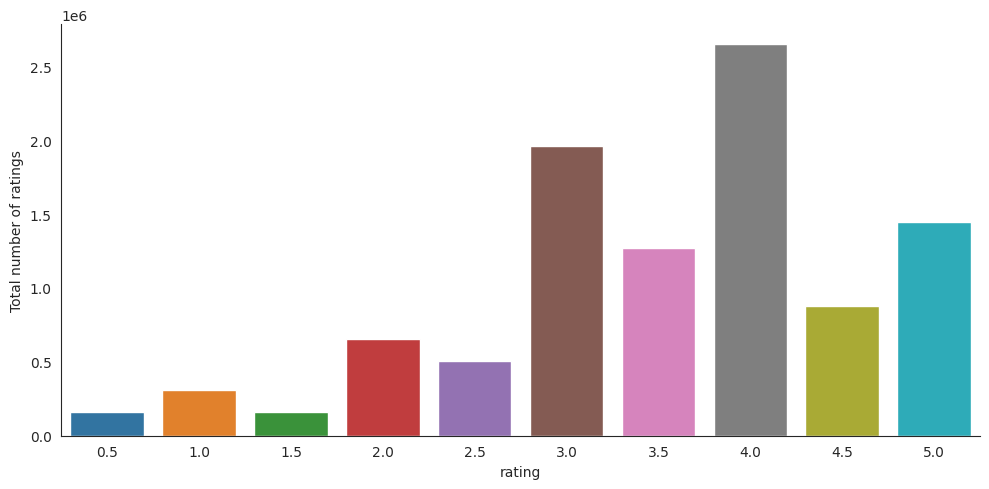

In [26]:
with sns.axes_style('white'):
    g = sns.catplot(data=train, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train["rating"])}')

In [27]:
#tosave = movies_df[['movieId', 'title', 'Genre_Tags']]
#tosave.to_csv('movies_clean.csv', index=False)

In [28]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0.0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a movie,
# with TF-IDF features as columns 
tf_gentag_matrix = tf.fit_transform(movies_df['Genre_Tags'])

In [29]:
# compute similarity between each movie vector within our matrix
#cosine_sim_gentag = cosine_similarity(tf_gentag_matrix, tf_gentag_matrix)
#print (cosine_sim_gentag.shape)

In [30]:
tf_gentag_matrix.shape[0]

62423

I was unable to successfully run the cosine_similarity on the matrix due to limited memory allocation here on Kaggle, i kept getting kernel out of memory. So i ran it on my local pc, saved the similarity scores in a dataframe. However, i noticed the data was very large(29.0GB). Tried converting all values to a float16 and i achieved a significant decrease in memory usage(dataframe now 7.3GB). Unfortuanately, this is still a huge data so i went back to my data for some more spelunking to figure out how best to move forward.
Looking at the test data which we are trying to build a model for, i noticed the majority of values here falls in the first 10 thousand movieids. So technically we dont need to use all the movies to build a similarity score to get a decent prediction. So we will try and figure out the amount of movies we need to get similarity scores for.

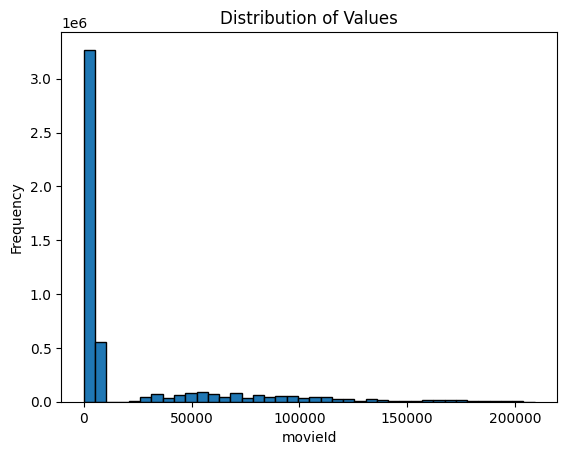

In [31]:
# distribution of movieIds in test data
test['movieId'].plot(kind='hist', bins=40, edgecolor='black')
plt.xlabel('movieId')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()

In [32]:
movies_df

,movieId,title,genres,tag,tags,Genre_Tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Owned imdb top 250 Pixar Pixar time travel chi...,toys computer animation pixar animation kids a...,ya life stereoscopic door day buddy acting cla...
1,2,Jumanji (1995),Adventure Children Fantasy,Robin Williams time travel fantasy based on ch...,adventure children fantasy kids special effect...,big effects day world joe dynamic in jungle fi...
2,3,Grumpier Old Men (1995),Comedy Romance,funny best friend duringcreditsstinger fishing...,sequel good sequel sequels comedy original gun...,original fever running wedding is movie best m...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,based on novel or book chick flick divorce int...,women chick flick divorce girlie movie romanti...,original infidelity feel drinking drama movie ...
4,5,Father of the Bride Part II (1995),Comedy,aging baby confidence contraception daughter g...,sequel good sequel father daughter relationshi...,original feel fever wedding movie chase confid...
...,...,...,...,...,...,...
62418,209157,We (2018),Drama,,,drama
62419,209159,Window of the Soul (2001),Documentary,,,documentary
62420,209163,Bad Poems (2018),Comedy Drama,,,comedy drama
62421,209169,A Girl Thing (2001),(no genres listed),,,(no_genres_listed)


In [33]:
# Get the movies that make up most of our test data set, these are the movies that
# the cosine similarity is of utmost importance.
common_movies = test['movieId'].value_counts().sort_values(ascending=False)[:10000]

In [34]:
percent_total = (common_movies.sum()) / len(test) * 100
percent_total

97.6663288679503

We can see that about 10,000 of our movies is what make up the majority of our test data. So we need to get the movieIds of these movies and use for cosine similarity analysis.

In [35]:
# Movie Ids of the most common movies in test dataset
# common_movies.index correspond to the movieIds of each movie
rel_movies_ind = common_movies.index.tolist()

In [36]:
# Then Filter the movies_df DataFrame based on the list of movieId (rel_movies_ind)
filtered_df = movies_df[movies_df['movieId'].isin(rel_movies_ind)]
# Retrieve the indices of the filtered rows
indices = filtered_df.index.tolist()

In [37]:
selected_tf_gentag_matrix = tf_gentag_matrix[indices]

In [38]:
selected_tf_gentag_matrix.shape[0]

10000

Now we compute the similarity scores of the selected movie

In [39]:
def incremental_cosine_similarity(tfidf_matrix, chunk_size=1000):
    n_samples = tfidf_matrix.shape[0]
    sim_matrix = np.zeros((n_samples, n_samples))

    for start in range(0, n_samples, chunk_size):
        end = min(start + chunk_size, n_samples)
        sim_matrix[start:end] = cosine_similarity(tfidf_matrix[start:end], tfidf_matrix)

    return sim_matrix

# compute similarity for subset of the matrix at a time
cosine_sim_gentag = incremental_cosine_similarity(selected_tf_gentag_matrix)

In [40]:
print (cosine_sim_gentag.shape)

(10000, 10000)


In [41]:
# Convert to DataFrame for easier viewing
cosine_sim_df = pd.DataFrame(cosine_sim_gentag, index=indices, columns=indices)

In [42]:
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,...,59963,60072,60090,60095,60400,60529,60869,60937,61005,61253
0,1.000000,0.059725,0.013946,0.016721,0.024605,0.012432,0.011333,0.043611,0.013605,0.030837,...,0.014061,0.026332,0.012187,0.010059,0.017578,0.008674,0.019516,0.025578,0.011791,0.010386
1,0.059725,1.000000,0.024390,0.037670,0.043323,0.007141,0.031491,0.067554,0.046949,0.049636,...,0.023922,0.044751,0.015496,0.011796,0.032103,0.029689,0.013298,0.034708,0.018001,0.039689
2,0.013946,0.024390,1.000000,0.038276,0.080275,0.007938,0.051058,0.027393,0.025955,0.022094,...,0.030665,0.055026,0.010882,0.015807,0.040411,0.038618,0.009831,0.039019,0.012650,0.042133
3,0.016721,0.037670,0.038276,1.000000,0.091671,0.019008,0.092505,0.115949,0.061397,0.010618,...,0.017017,0.065951,0.013847,0.007306,0.036378,0.021123,0.016718,0.036285,0.014776,0.041831
4,0.024605,0.043323,0.080275,0.091671,1.000000,0.010481,0.055764,0.048695,0.033170,0.022118,...,0.019030,0.025064,0.013314,0.025246,0.049075,0.018430,0.014162,0.015575,0.011203,0.027457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60529,0.008674,0.029689,0.038618,0.021123,0.018430,0.028460,0.045358,0.035176,0.051852,0.047618,...,0.055948,0.092562,0.030392,0.030205,0.067042,1.000000,0.047146,0.072428,0.032239,0.058624
60869,0.019516,0.013298,0.009831,0.016718,0.014162,0.025024,0.010567,0.018014,0.011076,0.009724,...,0.051122,0.075817,0.039712,0.025034,0.042252,0.047146,1.000000,0.028503,0.039416,0.054988
60937,0.025578,0.034708,0.039019,0.036285,0.015575,0.016197,0.042084,0.037081,0.022538,0.021246,...,0.033720,0.100469,0.034714,0.025013,0.033440,0.072428,0.028503,1.000000,0.029100,0.040698
61005,0.011791,0.018001,0.012650,0.014776,0.011203,0.041871,0.011144,0.014634,0.021251,0.007905,...,0.047127,0.046602,0.090153,0.065168,0.025990,0.032239,0.039416,0.029100,1.000000,0.068747


In [43]:
# Convenient indexes to map between movie id and indexes of 
# the movies dataframe
movie_ids = movies_df['movieId']
m_indices = pd.Series(movies_df.index, index=movies_df['movieId']).drop_duplicates()

In [44]:
def content_generate_rating_estimate(user_id, movie_id, rating_df, k=20, threshold=0.0):
    # Convert the movie_id to a numeric index for our 
    # similarity matrix
    m_idx = m_indices[movie_id]
    # check if reference movie has sim score
    if m_idx in indices:
        neighbors = [] # <-- Stores our collection of similarity values 

        # Gather the similarity ratings between each movie the user has rated
        # if index in cosine_sim_df and the reference movie
        for index, row in rating_df[rating_df['userId']==user_id].iterrows():
            m_idx1 = m_indices[row['movieId']]
            if m_idx1 in indices:
                sim = cosine_sim_df.loc[m_idx, m_idx1]
                neighbors.append((sim, row['rating']))
        # Select the top-N values from our collection
        k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

        # Compute the weighted average using similarity scores and 
        # user item ratings. 
        simTotal, weightedSum = 0, 0
        for (simScore, rating) in k_neighbors:
            # Ensure that similarity scores are above a given threshold
            if (simScore > threshold):
                simTotal += simScore
                weightedSum += simScore * rating
        try:
            predictedRating = weightedSum / simTotal
        except ZeroDivisionError:
            # Cold-start problem - No ratings given by user. 
            # Fallback to average rating of the movie if available,
            # then average user rating, and finally global average rating.
            movie_ratings = rating_df[rating_df['movieId'] == movie_id]['rating']
            if not movie_ratings.empty:
                predictedRating = np.mean(movie_ratings)
            else:
                user_ratings = rating_df[rating_df['userId'] == user_id]['rating']
                if not user_ratings.empty:
                    predictedRating = np.mean(user_ratings)
                else:
                    predictedRating = np.mean(rating_df['rating'])
        
        return predictedRating
    else:
        # Fallback strategy if the movie_id is not in the cosine similarity matrix
        # 1. Movie's average rating if available
        movie_ratings = rating_df[rating_df['movieId'] == movie_id]['rating']
        if not movie_ratings.empty:
            return np.mean(movie_ratings)
        
        # 2. User's average rating
        user_ratings = rating_df[rating_df['userId'] == user_id]['rating']
        if not user_ratings.empty:
            return np.mean(user_ratings)

        # 3. Global average rating if the user has not rated any movies and movie has no ratings
        return np.mean(rating_df['rating'])

## Test Algorithm on individual data points

In [45]:
# Subset of ratings from user 2501
train[train['userId'] == 2501][3:10]

,userId,movieId,rating
811315,2501,78499,4.5
823124,2501,164179,4.0
1365517,2501,95167,4.5
1461242,2501,122922,4.5
1484801,2501,68954,4.5
1687002,2501,1036,4.5
2006978,2501,3703,3.5


In [46]:
train[train['movieId'] == 177925]

,userId,movieId,rating
2925021,32253,177925,4.5


In [47]:
movie_id = 177925
actual_rating = train[(train['userId'] == 32253) & (train['movieId'] == movie_id)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(user_id=32253, movie_id=movie_id, rating_df=train)
print (f"Id - {movie_id}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

Id - 177925
---
Actual rating: 		 4.5
Predicted rating: 	 4.5


## Evaluate Algorithm on entire train data and calculate RMSE

In [48]:
# Apply prediction function to train data
#train['predicted_rating'] = train.apply(
    #lambda row: content_generate_rating_estimate(row['userId'], row['movieId'], train), axis=1)

# Calculate RMSE
#rmse = np.sqrt(mean_squared_error(train['rating'], train['predicted_rating']))
#print(f'RMSE: {rmse}')

In [49]:
# Apply prediction function to test data columns 'userId' and 'movieId'
#test['rating'] = test.progress_apply(
    #lambda row: content_generate_rating_estimate(row['userId'], row['movieId'], train), axis=1)

Tried applying the function to the train data to calculate rmse but it was gooing to take forever. and since we dont really need to generate prediction for the train data as it is just to evaluate model. I wont be applying the function directly as it take a very long while to apply the function to over 10M rows. I will be using parallel processing below. Also I will be using just 100k rows of the train data to calculate prediction accuracy to save time and get a quick overview of the algorithm performance.

In [50]:
sub_train = train.iloc[:100000]

In [51]:
def apply_content_generate_rating_estimate(row, rating_df):
    return content_generate_rating_estimate(row['userId'], row['movieId'], rating_df)

# Convert the DataFrame to a list of rows for parallel processing
rows = [row for _, row in sub_train.iterrows()]

# Parallel processing using joblib
num_cores = -1  # Use all available cores
results = Parallel(n_jobs=num_cores, backend="multiprocessing")(
    delayed(apply_content_generate_rating_estimate)(row, train) for row in tqdm(rows)
)

# Assign results back to the DataFrame
sub_train['prediction'] = results
sub_train['prediction'] = sub_train['prediction'].round(1).abs()

100%|██████████| 100000/100000 [1:28:30<00:00, 18.83it/s]


In [52]:
# Calculate prediction coefficient of determination
from sklearn.metrics import r2_score
y_true = sub_train['rating']  # Ground truth (true rating)
y_pred = sub_train['prediction']  # Predicted rating
# Calculate R2_score
r2 = r2_score(y_true, y_pred)

print(f"R-Squared: {r2:.2f}")

R-Squared: 0.83


# 3. Collaborative Filtering Approach

In [53]:
# Prepare data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

In [54]:
# Split train data into train and test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [55]:
# Train SVD model
svd = SVD()
# train algorithm on trainset
svd.fit(trainset)

In [56]:
# Make predictions on testset
predictions = svd.test(testset)

# Calculate and print RMSE
rmse = accuracy.rmse(predictions)

RMSE: 0.8339


In [57]:
# function to get rating predictions for the test data
def collaborative_rating(row, algo):
    return algo.predict(row['userId'], row['movieId']).est

In [58]:
# Apply prediction function to test data columns 'userId' and 'movieId'
test['rating1'] = test.apply(
    lambda row: collaborative_rating(row, svd), axis=1)
test.head()

,userId,movieId,rating1
0,1,2011,3.267083
1,1,4144,4.250089
2,1,5767,3.650474
3,1,6711,4.064521
4,1,7318,3.301733


In [59]:
subm_df1 = test[['userId', 'rating1']]
subm_df1['rating1'] = subm_df1['rating1'].round(1).abs()
subm_df1.columns = ['Id', 'rating']
subm_df1.to_csv('sample_submission1.csv', index=False)
subm_df1.head()

,Id,rating
0,1,3.3
1,1,4.3
2,1,3.7
3,1,4.1
4,1,3.3


## Retrain model on full train data

In [60]:
# Retrain algorithm on entire train data
train_full = data.build_full_trainset()
svd.fit(train_full)

In [61]:
# Apply prediction function to test data columns 'userId' and 'movieId'
test['rating2'] = test.apply(
    lambda row: collaborative_rating(row, svd), axis=1)
test.head()

,userId,movieId,rating1,rating2
0,1,2011,3.267083,3.473409
1,1,4144,4.250089,4.286627
2,1,5767,3.650474,3.392728
3,1,6711,4.064521,3.723041
4,1,7318,3.301733,3.385579


In [62]:
subm_df2 = test[['userId', 'rating2']]
subm_df2['rating2'] = subm_df2['rating2'].round(1).abs()
subm_df2.columns = ['Id', 'rating']
subm_df2.to_csv('sample_submission2.csv', index=False)
subm_df2.head()

,Id,rating
0,1,3.5
1,1,4.3
2,1,3.4
3,1,3.7
4,1,3.4


# 4. Hybrid Approach

In [63]:
# We could use this function below
# But we wont, as it is a waste of resources to call the algorithm again
# Function to combine the two models above
def hybrid_predict(row, algo, rating_df):
    collab_pred = collaborative_rating(row, algo).est
    content_pred = content_generate_rating_estimate(row['userId'], row['movieId'], rating_df)
    return (0.5 * collab_pred) + (0.5 * content_pred)

We will simply use all the ratings columns we have generated to get the average of both methods

In [64]:
'''test['rating3'] = (0.5 * test['rating']) + (0.5 * test['rating2'])
subm_df3 = test[['Id', 'rating3']]
subm_df3['rating3'] = subm_df2['rating3'].round(1).abs()
subm_df3.columns = ['Id', 'rating']
subm_df3.to_csv('sample_submission3.csv', index=False)
subm_df3.head()'''

"test['rating3'] = (0.5 * test['rating']) + (0.5 * test['rating2'])\nsubm_df3 = test[['Id', 'rating3']]\nsubm_df3['rating3'] = subm_df2['rating3'].round(1).abs()\nsubm_df3.columns = ['Id', 'rating']\nsubm_df3.to_csv('sample_submission3.csv', index=False)\nsubm_df3.head()"